Using the PyTorch ANN framework, please implement the Fashion MNIST classification.
https://github.com/zalandoresearch/fashion-mnist


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Create train and test datasets

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST(
    root="./data", train=True, transform=transforms.ToTensor(), download=True
)

test_dataset = torchvision.datasets.FashionMNIST(
    root="./data", train=False, transform=transforms.ToTensor()
)

How many labels do we have?

In [ ]:
labels = train_dataset.targets
unique_labels = torch.unique(labels)
print(len(unique_labels))

10


What's the image size?

In [ ]:
image, label = train_dataset[0]
image.shape

torch.Size([1, 28, 28])

Let's print some of the examples

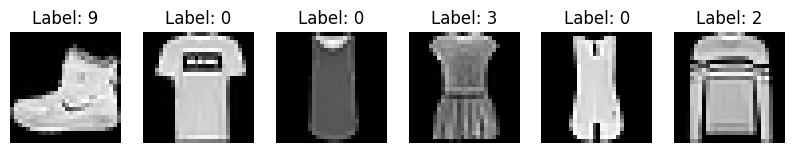

In [ ]:
def show_images_with_numeric_labels(images, labels, num_images=6):
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        image = images[i].squeeze()
        plt.imshow(image, cmap="gray")
        plt.title(f"Label: {labels[i].item()}")
        plt.axis("off")
    plt.show()


num_samples = 6
samples, labels = next(
    iter(torch.utils.data.DataLoader(train_dataset, batch_size=num_samples))
)

show_images_with_numeric_labels(samples, labels)

Now, we need to set up the hyperparameters.

In [ ]:
input_size = image.shape[1] * image.shape[2]
hidden_size = 512
num_classes = len(unique_labels)
num_epochs = 10
batch_size = 100
learning_rate = 0.001

Check the number of instances

In [ ]:
print(len(train_dataset))
print(len(test_dataset))

60000
10000


Load the data

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Define the ANN - in this case we will use fully connected neural network with one hidden layer

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # input layer to hidden layer
        self.relu = nn.ReLU()  # activation function
        self.fc2 = nn.Linear(hidden_size, num_classes)  # hidden layer to output layer

    def forward(self, x):
        x = x.view(-1, input_size)  # flatten the image
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

Define the test function to evaluate the model

In [ ]:
def test_model(model):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

Define the training function, allowing to test different optimizers

In [ ]:
def train_model(optimizer_name, optimizer, num_epochs=10):
    print(f"Training using {optimizer_name}...")

    criterion = nn.CrossEntropyLoss()

    losses = []
    accuracies = []

    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backward and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total
        losses.append(epoch_loss)
        accuracies.append(accuracy)

        print(
            f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%"
        )

    # test the model
    test_accuracy = test_model(model)
    print(f"Test Accuracy using {optimizer_name}: {test_accuracy:.2f}%\n")
    return test_accuracy, losses, accuracies

Initialize the model

In [ ]:
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

Define the optimizers to test

In [ ]:
optimizers = {
    "SGD": optim.SGD(model.parameters(), lr=0.01),
    "SGD with Momentum": optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
    "Adam": optim.Adam(model.parameters(), lr=0.001),
    "RMSprop": optim.RMSprop(model.parameters(), lr=0.001),
    "Adagrad": optim.Adagrad(model.parameters(), lr=0.01),
}

Compare results

In [ ]:
results = {}
for opt_name, opt in optimizers.items():
    # reset params
    model.apply(
        lambda m: m.reset_parameters() if hasattr(m, "reset_parameters") else None
    )
    accuracy, losses, accuracies = train_model(opt_name, opt, num_epochs=num_epochs)
    results[opt_name] = {
        "accuracy": accuracy,
        "losses": losses,
        "accuracies": accuracies,
    }

Training using SGD...
Epoch [1/10], Loss: 1.2589, Accuracy: 64.08%
Epoch [2/10], Loss: 0.7446, Accuracy: 74.89%
Epoch [3/10], Loss: 0.6363, Accuracy: 78.86%
Epoch [4/10], Loss: 0.5782, Accuracy: 80.71%
Epoch [5/10], Loss: 0.5424, Accuracy: 81.80%
Epoch [6/10], Loss: 0.5176, Accuracy: 82.53%
Epoch [7/10], Loss: 0.4994, Accuracy: 83.15%
Epoch [8/10], Loss: 0.4851, Accuracy: 83.49%
Epoch [9/10], Loss: 0.4738, Accuracy: 83.75%
Epoch [10/10], Loss: 0.4637, Accuracy: 84.16%
Test Accuracy using SGD: 82.87%

Training using SGD with Momentum...
Epoch [1/10], Loss: 0.6720, Accuracy: 77.32%
Epoch [2/10], Loss: 0.4546, Accuracy: 83.97%
Epoch [3/10], Loss: 0.4145, Accuracy: 85.58%
Epoch [4/10], Loss: 0.3855, Accuracy: 86.45%
Epoch [5/10], Loss: 0.3680, Accuracy: 87.00%
Epoch [6/10], Loss: 0.3485, Accuracy: 87.49%
Epoch [7/10], Loss: 0.3357, Accuracy: 88.07%
Epoch [8/10], Loss: 0.3217, Accuracy: 88.53%
Epoch [9/10], Loss: 0.3122, Accuracy: 88.84%
Epoch [10/10], Loss: 0.3036, Accuracy: 89.04%
Test Ac

Plot losses

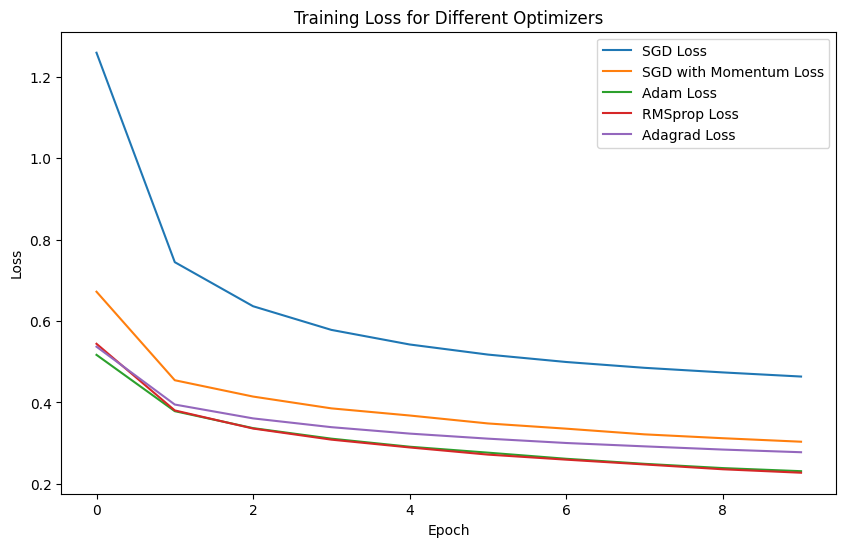

In [ ]:
plt.figure(figsize=(10, 6))
for opt_name, result in results.items():
    plt.plot(result["losses"], label=f"{opt_name} Loss")

plt.title("Training Loss for Different Optimizers")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Plot accuracies

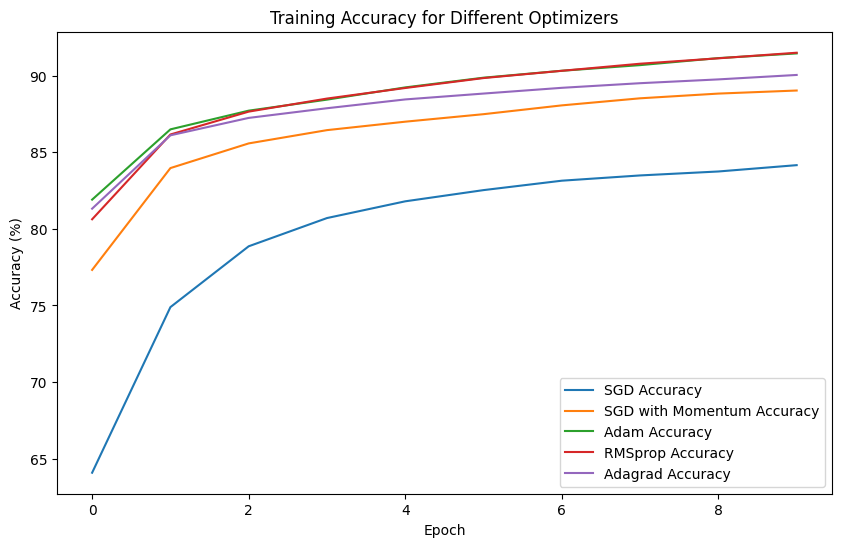

In [ ]:
plt.figure(figsize=(10, 6))
for opt_name, result in results.items():
    plt.plot(result["accuracies"], label=f"{opt_name} Accuracy")

plt.title("Training Accuracy for Different Optimizers")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()